In [12]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset as BaseDataset
import os
import cv2
import numpy as np
from time import time


In [65]:

write_to_path = "/home/ufh6ft"
model_name = "trained_model_w_25"



In [66]:
def dice_score(target, pred):
    intersection = np.sum(  np.multiply(target, pred)  )
    cardinality = np.sum(target) + np.sum(pred)
    dice_score = 2. * intersection / (cardinality + 0.00001)
    return min(1, dice_score)
def print_minmax(x):
    print(f"Min = {np.min(x)}, Max = {np.max(x)}")

In [67]:
class CardiacDataSet(BaseDataset):

    def __init__(self, train):

#         self.CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
#                         'tree', 'signsymbol', 'fence', 'car',
#                         'pedestrian', 'bicyclist', 'unlabelled']
        self.CLASSES = ['class0', 'class1']

        root_dir = write_to_path+"/mlia/data_imgs_aug"
        classes = self.CLASSES

        if train:
            self.raw_images_dir = os.path.join(root_dir, 'train')
            self.masked_images_dir = os.path.join(root_dir, 'trainannot')
        else:
            self.raw_images_dir = os.path.join(root_dir, 'test')
            self.masked_images_dir = os.path.join(root_dir, 'testannot')

        self.ids = os.listdir(self.raw_images_dir)
        
        self.ids.sort()
        print(f"ids = {(self.ids[:5])}\n")
        self.images_fps = [os.path.join(self.raw_images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(self.masked_images_dir, image_id) for image_id in self.ids]
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        
        
        print(f"imgs = {(self.images_fps[:5])}\n")
        print(f"masks = {(self.masks_fps[:5])}\n")
        
    def __getitem__(self, i):

        image = cv2.imread(self.images_fps[i], 0)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = mask.astype('float')/255.0
        return np.reshape(image, (256, 256, 1)).transpose(2, 1, 0).astype('float'), mask


    def __len__(self):
        return len(self.ids)


In [68]:
train_dataset = CardiacDataSet(train=True)
test_dataset = CardiacDataSet(train=False)

print(f"len(train_dataset) = {len(train_dataset)},  len(test_dataset) = {len(test_dataset)}")

print(np.array(train_dataset[0][0], dtype=int).shape)
print(np.array(train_dataset[0][1], dtype=int).shape)

print(np.array(train_dataset[0][0], dtype=int))
print(np.array(train_dataset[0][1], dtype=int))

ids = ['img_00000.png', 'img_00001.png', 'img_00002.png', 'img_00003.png', 'img_00004.png']

imgs = ['/home/ufh6ft/mlia/data_imgs_aug/train/img_00000.png', '/home/ufh6ft/mlia/data_imgs_aug/train/img_00001.png', '/home/ufh6ft/mlia/data_imgs_aug/train/img_00002.png', '/home/ufh6ft/mlia/data_imgs_aug/train/img_00003.png', '/home/ufh6ft/mlia/data_imgs_aug/train/img_00004.png']

masks = ['/home/ufh6ft/mlia/data_imgs_aug/trainannot/img_00000.png', '/home/ufh6ft/mlia/data_imgs_aug/trainannot/img_00001.png', '/home/ufh6ft/mlia/data_imgs_aug/trainannot/img_00002.png', '/home/ufh6ft/mlia/data_imgs_aug/trainannot/img_00003.png', '/home/ufh6ft/mlia/data_imgs_aug/trainannot/img_00004.png']

ids = ['img_00000.png', 'img_00001.png', 'img_00002.png', 'img_00003.png', 'img_00004.png']

imgs = ['/home/ufh6ft/mlia/data_imgs_aug/test/img_00000.png', '/home/ufh6ft/mlia/data_imgs_aug/test/img_00001.png', '/home/ufh6ft/mlia/data_imgs_aug/test/img_00002.png', '/home/ufh6ft/mlia/data_imgs_aug/test/img_00003.pn

In [69]:
BATCH_SZ = 16

def dataloader():
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SZ, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SZ, shuffle=False, num_workers=2)

    return train_loader, test_loader

In [70]:
class SegNet(nn.Module):
    def __init__(self, in_chan_num, out_chan_num):
        super(SegNet, self).__init__()
        self.encoder1 = Encorder2Convs(in_chan_num, 64)
        self.encoder2 = Encorder2Convs(64, 128)
        self.encoder3 = Encorder3Convs(128, 256)
        self.encoder4 = Encorder3Convs(256, 512)
        self.encoder5 = Encorder3Convs(512, 512)

        self.decoder1 = Decorder3Convs(512, 512)
        self.decoder2 = Decorder3Convs(512, 256)
        self.decoder3 = Decorder3Convs(256, 128)
        self.decoder4 = Decorder2Convs(128, 64)
        self.decoder5 = Decorder2Convs(64, out_chan_num)

        self.encoder_list = [self.encoder1, self.encoder2, self.encoder3, self.encoder4, self.encoder5]

        if in_chan_num == 3:
            self.set_weight()

    def forward(self, input):
        output, indices1, unpooled_shape1 = self.encoder1(input)
        output, indices2, unpooled_shape2 = self.encoder2(output)
        output, indices3, unpooled_shape3 = self.encoder3(output)
        output, indices4, unpooled_shape4 = self.encoder4(output)
        output, indices5, unpooled_shape5 = self.encoder5(output)

        output = self.decoder1(output, indices5, unpooled_shape5)
        output = self.decoder2(output, indices4, unpooled_shape4)
        output = self.decoder3(output, indices3, unpooled_shape3)
        output = self.decoder4(output, indices2, unpooled_shape2)
        output = self.decoder5(output, indices1, unpooled_shape1)

        return output

    def set_weight(self):
        vgg16 = models.vgg16(pretrained=True)
        self.vgg16_conv2d_layers = [layer for layer in vgg16.features if isinstance(layer, nn.Conv2d)]

        for encorder in self.encoder_list:
            if isinstance(encorder, Encorder2Convs):
                self._set_weight_encorder2convs(encorder)
            if isinstance(encorder, Encorder3Convs):
                self._set_weight_encorder3convs(encorder)

        assert (len(self.vgg16_conv2d_layers)) == 0

    def _set_weight_encorder2convs(self, encorder):
        self.__set_weight(encorder.conv_batch_relu1.conv)
        self.__set_weight(encorder.conv_batch_relu2.conv)

    def _set_weight_encorder3convs(self, encorder):
        self.__set_weight(encorder.conv_batch_relu1.conv)
        self.__set_weight(encorder.conv_batch_relu2.conv)
        self.__set_weight(encorder.conv_batch_relu3.conv)

    def __set_weight(self, conv_layer):
        conv_layer.weight.data = self.vgg16_conv2d_layers.pop(0).weight.data


class Encorder2Convs(nn.Module):
    def __init__(self, in_chan_num, out_chan_num):
        super(Encorder2Convs, self).__init__()
        self.conv_batch_relu1 = ConvBatchReLU(in_chan_num, out_chan_num)
        self.conv_batch_relu2 = ConvBatchReLU(out_chan_num, out_chan_num)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, input):
        output = self.conv_batch_relu1(input)
        output = self.conv_batch_relu2(output)
        unpooled_shape = output.size()
        output, indices = self.pool(output)

        return output, indices, unpooled_shape


class Encorder3Convs(nn.Module):
    def __init__(self, in_chan_num, out_chan_num):
        super(Encorder3Convs, self).__init__()
        self.conv_batch_relu1 = ConvBatchReLU(in_chan_num, out_chan_num)
        self.conv_batch_relu2 = ConvBatchReLU(out_chan_num, out_chan_num)
        self.conv_batch_relu3 = ConvBatchReLU(out_chan_num, out_chan_num)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, input):
        output = self.conv_batch_relu1(input)
        output = self.conv_batch_relu2(output)
        output = self.conv_batch_relu3(output)
        unpooled_shape = output.size()
        output, indices = self.pool(output)

        return output, indices, unpooled_shape


class Decorder2Convs(nn.Module):
    def __init__(self, in_chan_num, out_chan_num):
        super(Decorder2Convs, self).__init__()
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.conv_batch_relu1 = ConvBatchReLU(in_chan_num, out_chan_num)
        self.conv_batch_relu2 = ConvBatchReLU(out_chan_num, out_chan_num)

    def forward(self, input, indices, output_shape):
        output = self.unpool(input, indices, output_shape)
        output = self.conv_batch_relu1(output)
        output = self.conv_batch_relu2(output)

        return output


class Decorder3Convs(nn.Module):
    def __init__(self, in_chan_num, out_chan_num):
        super(Decorder3Convs, self).__init__()
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.conv_batch_relu1 = ConvBatchReLU(in_chan_num, out_chan_num)
        self.conv_batch_relu2 = ConvBatchReLU(out_chan_num, out_chan_num)
        self.conv_batch_relu3 = ConvBatchReLU(out_chan_num, out_chan_num)

    def forward(self, input, indices, output_shape):
        output = self.unpool(input, indices, output_shape)
        output = self.conv_batch_relu1(output)
        output = self.conv_batch_relu2(output)
        output = self.conv_batch_relu3(output)

        return output


class ConvBatchReLU(nn.Module):
    def __init__(self, in_chan_num, out_chan_num):
        super(ConvBatchReLU, self).__init__()
        self.conv = nn.Conv2d(in_chan_num, out_chan_num, kernel_size=3, stride=1, padding=1)
        self.batch_norm = nn.BatchNorm2d(out_chan_num)
        self.relu = nn.ReLU()

    def forward(self, input):
        output = self.conv(input)
        output = self.batch_norm(output)
        output = self.relu(output)

        return output

#   VGG16_Atchitecture:
#     Sequential(
#   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (1): ReLU(inplace)
#   (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (3): ReLU(inplace)
#   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
#   (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (6): ReLU(inplace)
#   (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (8): ReLU(inplace)
#   (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
#   (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (11): ReLU(inplace)
#   (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (13): ReLU(inplace)
#   (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (15): ReLU(inplace)
#   (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
#   (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (18): ReLU(inplace)
#   (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (20): ReLU(inplace)
#   (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (22): ReLU(inplace)
#   (23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
#   (24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (25): ReLU(inplace)
#   (26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (27): ReLU(inplace)
#   (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#   (29): ReLU(inplace)
#   (30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
# )



In [71]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device = {device}")

seg = SegNet(1, 2).to(device)
seg.load_state_dict(torch.load(f"{write_to_path}/mlia/results/{model_name}"))

Device = cuda


<All keys matched successfully>

In [88]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device = {device}")

dss = []

for i in range(10):
    pten = torch.tensor(np.array([test_dataset[i][0]]), dtype=torch.float, device=device)
    
#     print(np.array([test_dataset[i][0]]).shape)
    
    pred = seg(pten)
    
    p1 = np.array(pred.cpu().data.numpy())

    prednp = np.reshape(p1, (2, 256, 256))

    p2 = np.argmax(prednp, axis=0)
    
    ds = dice_score(np.array(test_dataset[i][1], dtype=int), p2)
    
    print(f"Test Image {i+1}. Dice score = {ds:.4f}")
    
    dss.append(ds)
    
print(f"Mean Dice Score (for labeled test set) = {sum(dss)/len(dss) :.4f}")
    

Device = cuda
Test Image 1. Dice score = 0.7659
Test Image 2. Dice score = 0.5121
Test Image 3. Dice score = 0.7681
Test Image 4. Dice score = 0.8191
Test Image 5. Dice score = 0.7518
Test Image 6. Dice score = 0.7884
Test Image 7. Dice score = 0.7767
Test Image 8. Dice score = 0.8060
Test Image 9. Dice score = 0.8166
Test Image 10. Dice score = 0.6899
Mean Dice Score (for labeled test set) = 0.7495


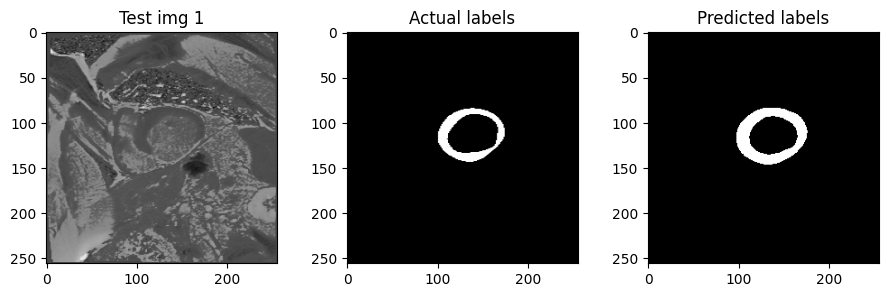

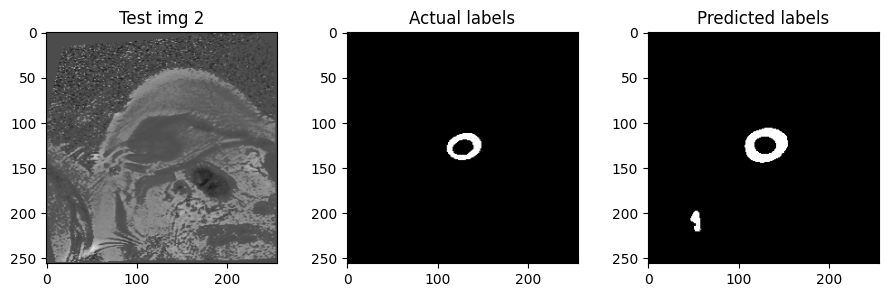

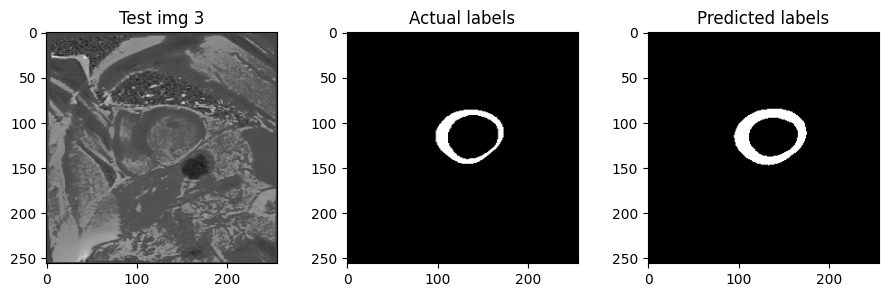

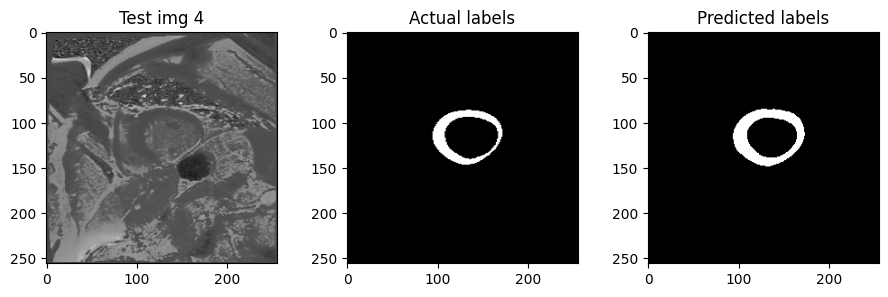

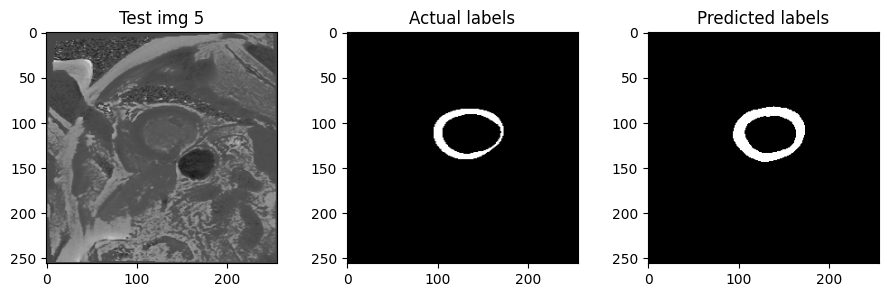

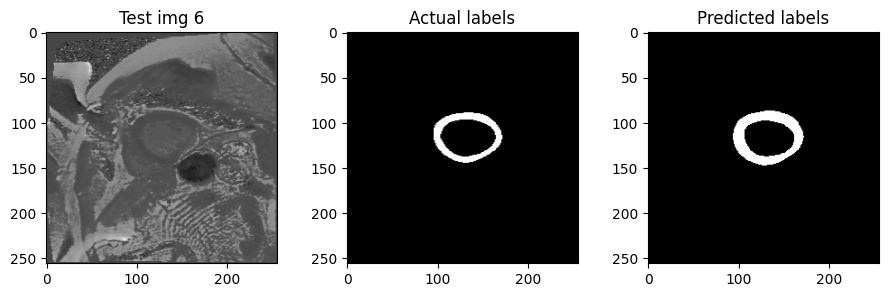

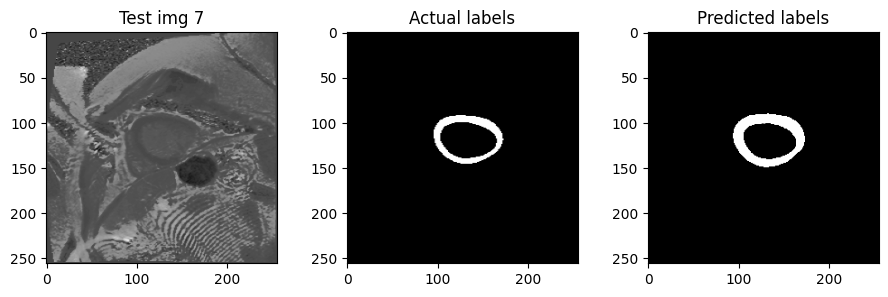

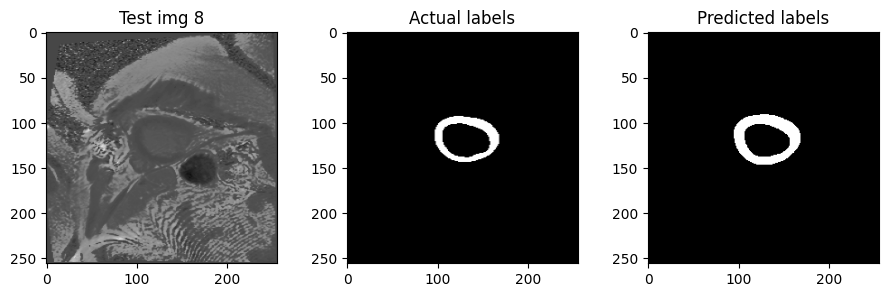

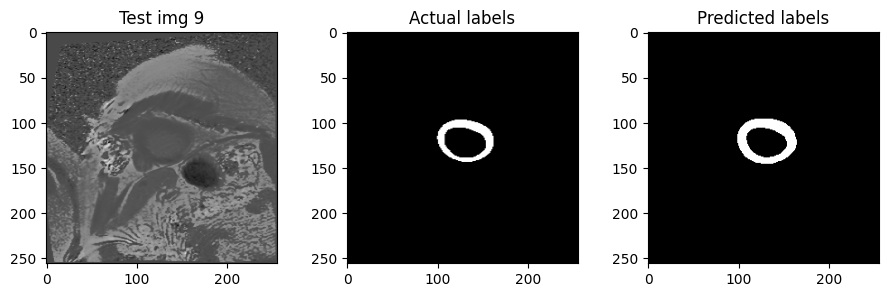

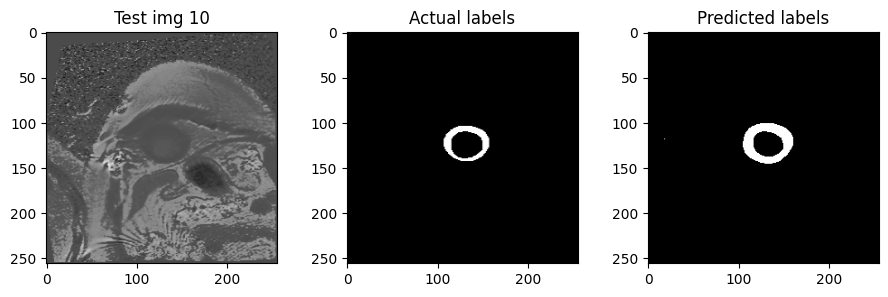

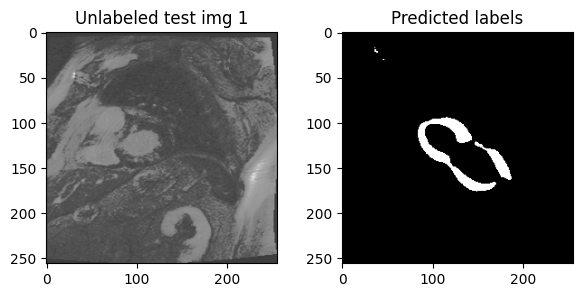

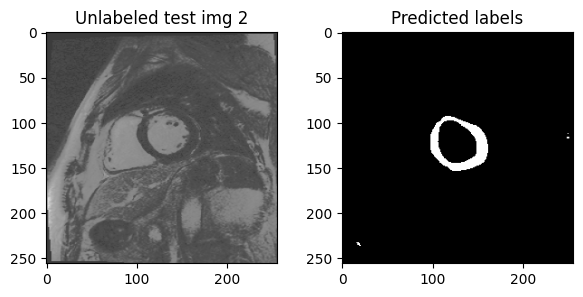

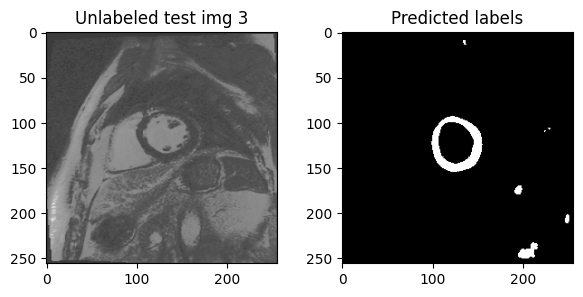

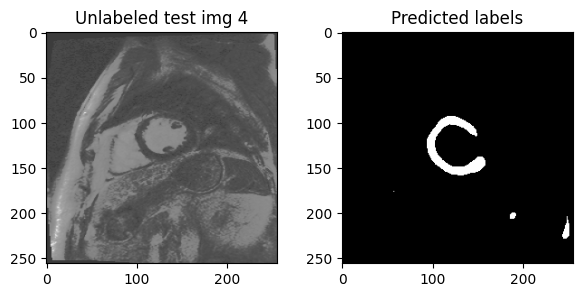

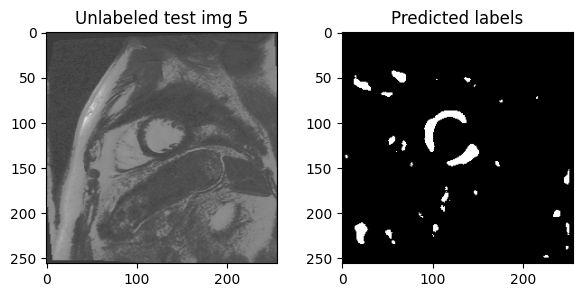

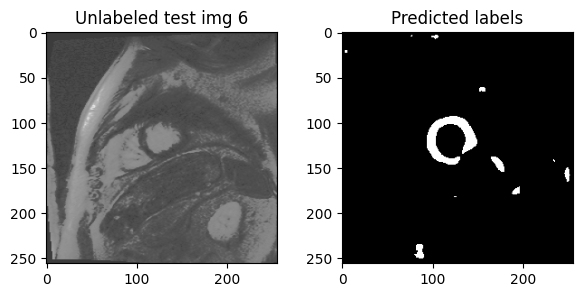

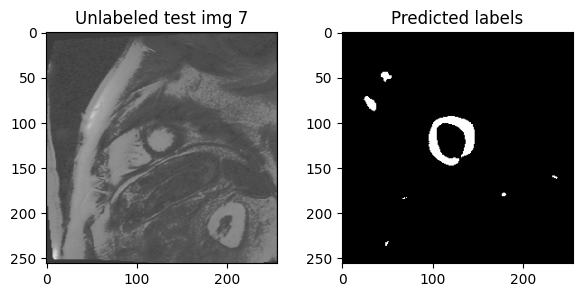

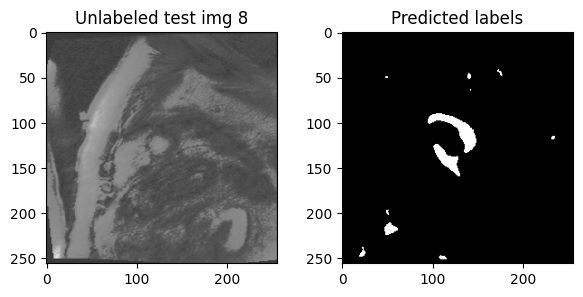

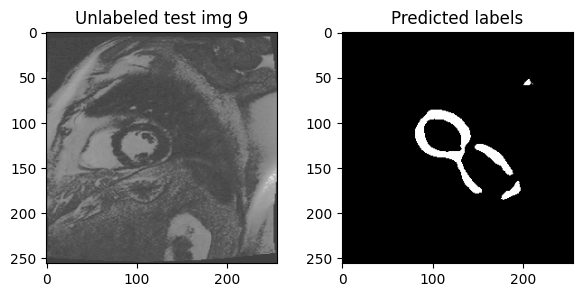

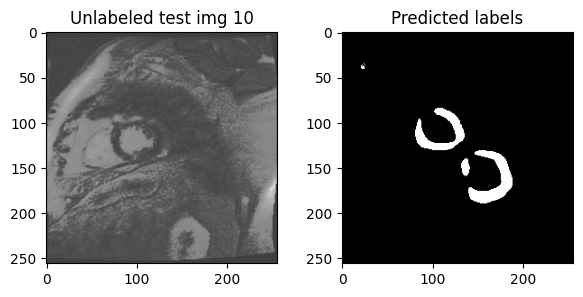

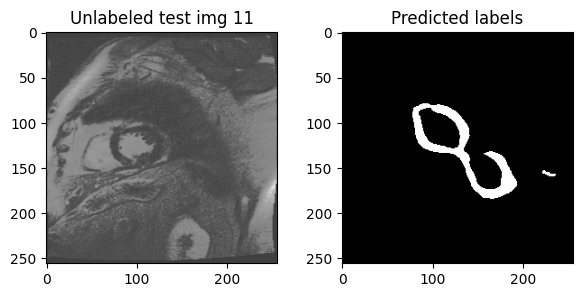

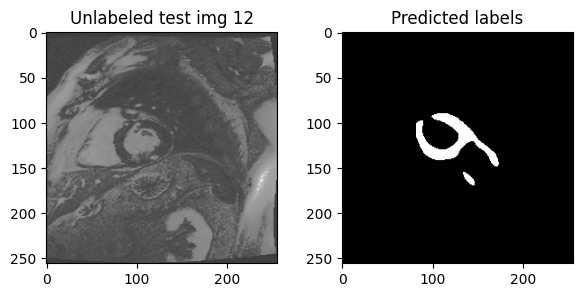

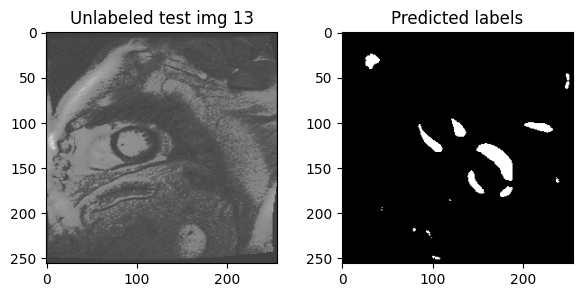

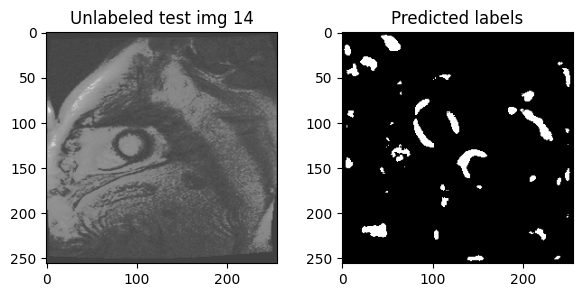

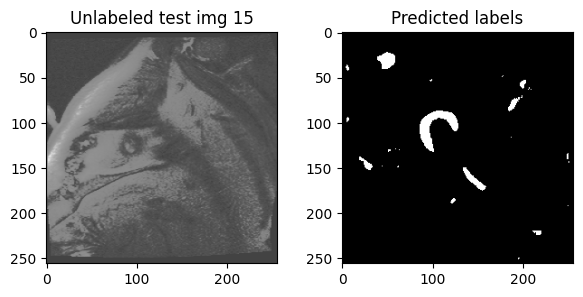

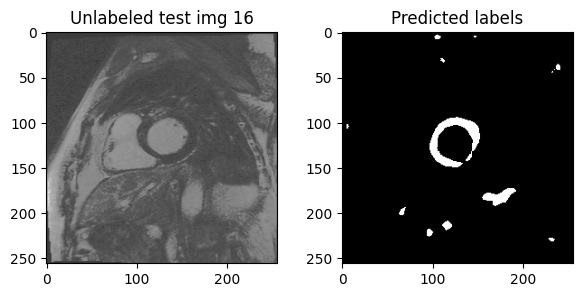

In [84]:
lBase = f"{write_to_path}/mlia/data_imgs_aug/test/"
lBaseY = f"{write_to_path}/mlia/data_imgs_aug/testannot/"

lTestPaths = [lBase+"img_"+("0"*(5 - len(str(ct)))) + str(ct) +".png" for ct in range(10)]
lTestPathsY = [lBaseY+"img_"+("0"*(5 - len(str(ct)))) + str(ct) +".png" for ct in range(10)]

# print(lTestPaths)
# print(lTestPathsY)

print("\n\n")
ct = 0
for p, pY in zip(lTestPaths, lTestPathsY):
#     print(f"Test img {ct+1}")
    ct+=1

    im = cv2.imread(p, 0)
    imY = cv2.imread(pY, 0)
    
#     print_minmax(im)
#     print_minmax(imY)
    
    image = np.reshape(im, (256, 256, 1)).transpose(2, 1, 0).astype('float')
    
    pten = torch.tensor(np.reshape( np.array(image) , (1, 1, 256, 256)), dtype=torch.float, device=device)
    
#     print(np.array(image).shape)
    
    pred = seg(pten)
    
    p1 = np.array(pred.cpu().data.numpy())

    prednp = np.reshape(p1, (2, 256, 256))

    p2 = np.argmax(prednp, axis=0)
    
    fig, ax = plt.subplots(1, 3, figsize=(11, 3))
    ax[0].set_title(f"Test img {ct}")
    ax[1].set_title(f"Actual labels")
    ax[2].set_title(f"Predicted labels")
    
    ax[0].imshow(im, cmap='gray', vmin=0, vmax=255)
    ax[1].imshow(imY, cmap='gray', vmin=0, vmax=255)
    ax[2].imshow(p2*255, cmap='gray', vmin=0, vmax=255)
    plt.show()

print("="*100)

nlBase = f"{write_to_path}/mlia/data_imgs_aug/testNoLabel/"

nlTestPaths = [nlBase+"img_"+("0"*(5 - len(str(ct)))) + str(ct) +".png" for ct in range(16)]

# print(nlTestPaths)

print("\n\n")
ct = 0
for p in nlTestPaths:
#     print(f"Unlabeled Test img {ct+1}")
    ct+=1

    im = cv2.imread(p, 0)
    
#     print_minmax(im)
    
    image = np.reshape(im, (256, 256, 1)).transpose(2, 1, 0).astype('float')
    
    pten = torch.tensor(np.reshape( np.array(image) , (1, 1, 256, 256)), dtype=torch.float, device=device)
    
#     print(np.array(image).shape)
    
    pred = seg(pten)
    
    p1 = np.array(pred.cpu().data.numpy())

    prednp = np.reshape(p1, (2, 256, 256))

    p2 = np.argmax(prednp, axis=0)
    
    fig, ax = plt.subplots(1, 2, figsize=(7, 3))
#     fig.suptitle(f"Unlabeled Test img {ct}")
    ax[0].set_title(f"Unlabeled test img {ct}")
    ax[1].set_title(f"Predicted labels")
    ax[0].imshow(im, cmap='gray', vmin=0, vmax=255)
    ax[1].imshow(p2*255, cmap='gray', vmin=0, vmax=255)
    plt.show()
    
    
    
    
    
    
    